In [135]:
import pandas as pd
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine,correlation
from datetime import datetime, timedelta

# 1. Loading data

In [396]:
genres= pd.read_csv('raw_data/ml-100k/u.genre', sep='|')

In [428]:
# 1. User's Dataset
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('raw_data/ml-100k/u.user', sep='|', names=u_cols,
                    encoding='latin-1', parse_dates=True) 
# 2. Rating dataset
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('raw_data/ml-100k/u.data', sep='\t', names=r_cols,
                      encoding='latin-1')

# 3.Movies Dataset
m_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url', 'unknown',
         'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary',
         'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
         'Thriller', 'War', 'Western']
movies = pd.read_csv('raw_data/ml-100k/u.item', sep='|', names=m_cols,
                     encoding='latin-1')
# 4. Genres
genres= pd.read_csv('raw_data/ml-100k/u.genre', sep='\t')

# 5. Merge all dataset
movie_ratings = pd.merge(movies, ratings)
df = pd.merge(movie_ratings,users)

# 6. Drop unused columns
df.drop(df.columns[[3,4,5]], axis=1, inplace=True)
ratings.drop( "unix_timestamp", inplace = True, axis = 1 ) 

df.head(5)

,movie_id,title,release_date,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Thriller,War,Western,user_id,rating,unix_timestamp,age,sex,occupation,zip_code
0,1,Toy Story (1995),01-Jan-1995,0,0,1,1,1,0,0,...,0,0,0,308,4,887736532,60,M,retired,95076
1,4,Get Shorty (1995),01-Jan-1995,1,0,0,0,1,0,0,...,0,0,0,308,5,887737890,60,M,retired,95076
2,5,Copycat (1995),01-Jan-1995,0,0,0,0,0,1,0,...,1,0,0,308,4,887739608,60,M,retired,95076
3,7,Twelve Monkeys (1995),01-Jan-1995,0,0,0,0,0,0,0,...,0,0,0,308,4,887738847,60,M,retired,95076
4,8,Babe (1995),01-Jan-1995,0,0,0,1,1,0,0,...,0,0,0,308,5,887736696,60,M,retired,95076


# 2. Exploratory data analysis

In [6]:
n_users = df.user_id.unique().shape[0]
n_items = df.movie_id.unique().shape[0]
print ('Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_items))

Number of users = 943 | Number of movies = 1682


### 2.1 Movies

In [7]:
movie_stats = df.groupby('title').agg({'rating' : [np.size, np.mean]})
movie_stats.head(10)

rating          
                                              size      mean
title                                                       
'Til There Was You (1997)                        9  2.333333
1-900 (1994)                                     5  2.600000
101 Dalmatians (1996)                          109  2.908257
12 Angry Men (1957)                            125  4.344000
187 (1997)                                      41  3.024390
2 Days in the Valley (1996)                     93  3.225806
20,000 Leagues Under the Sea (1954)             72  3.500000
2001: A Space Odyssey (1968)                   259  3.969112
3 Ninjas: High Noon At Mega Mountain (1998)      5  1.000000
39 Steps, The (1935)                            59  4.050847

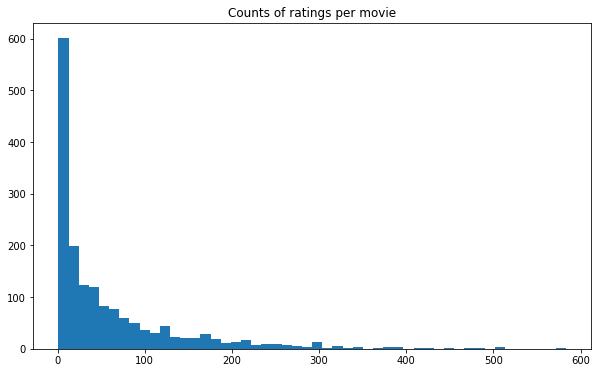

In [8]:
plt.figure(figsize=(10,6))
plt.hist(movie_stats['rating']['size'].values, bins=50)
plt.title('Counts of ratings per movie')
plt.show()

In [9]:
min_50 = movie_stats['rating']['size'] >= 50
movie_stats[min_50].sort_values([('rating', 'mean')], ascending=False).head()

rating          
                                                     size      mean
title                                                              
Close Shave, A (1995)                                 112  4.491071
Schindler's List (1993)                               298  4.466443
Wrong Trousers, The (1993)                            118  4.466102
Casablanca (1942)                                     243  4.456790
Wallace & Gromit: The Best of Aardman Animation...     67  4.447761

,4,3,5,2,1
Ratings,34174,27145,21201,11370,6110


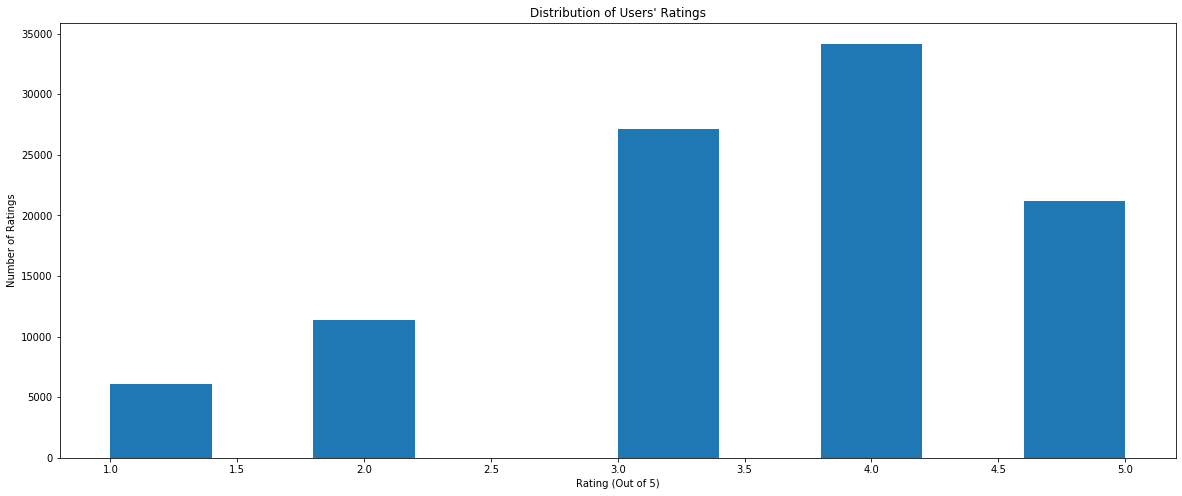

In [10]:
plt.figure(figsize=(20,8))
ratings.rating.plot.hist(bins=10, )
plt.title("Distribution of Users' Ratings")
plt.ylabel('Number of Ratings')
plt.xlabel('Rating (Out of 5)')

rating_count = pd.DataFrame(ratings.rating.value_counts()).T.rename({'rating':'Ratings'})
rating_count

,30,25,22,28,27,26,24,29,20,32,...,58,64,68,69,62,11,10,73,66,7
Total Users by Age,39,38,37,36,35,34,33,32,32,28,...,3,2,2,2,2,1,1,1,1,1


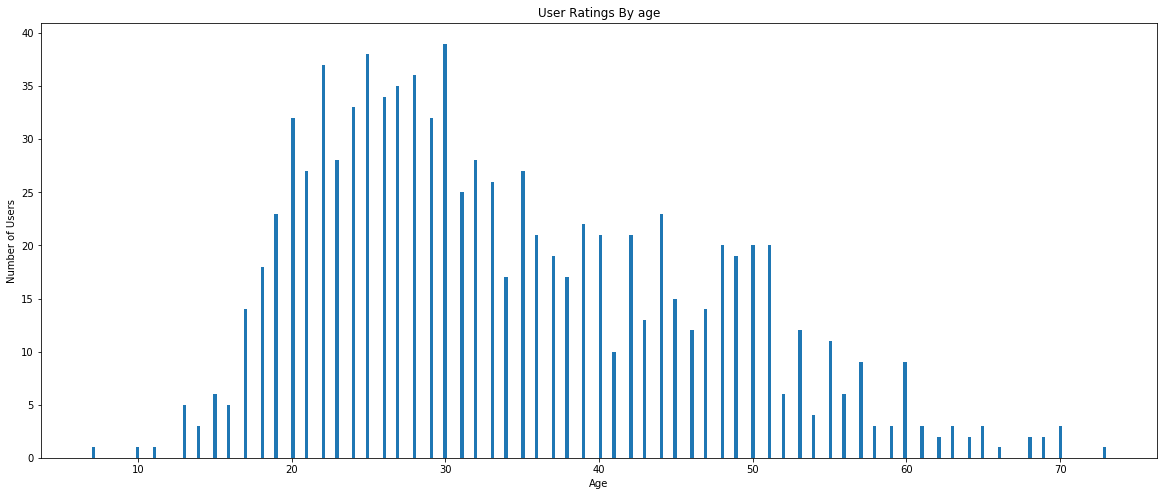

In [11]:
plt.figure(figsize=(20,8))
users.age.plot.hist(bins = 300)
plt.title("User Ratings By age")
plt.ylabel('Number of Users')
plt.xlabel('Age')

user_age_count = pd.DataFrame(users.age.value_counts()).T.rename({'age':'Total Users by Age'})
user_age_count

### 2.2 Rating

In [12]:
ratings_matrix = ratings.pivot_table(index=['movie_id'],columns=['user_id'],values='rating').reset_index(drop=True)
ratings_matrix.fillna(0, inplace=True)
ratings_matrix.head()

user_id,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
0,5.0,4.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,4.0,...,2.0,3.0,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0
1,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,...,5.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
4,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
movie_similarity = 1 - pairwise_distances(ratings_matrix.as_matrix(), metric="cosine")
np.fill_diagonal(movie_similarity, 0)
ratings_matrix = pd.DataFrame(movie_similarity)
ratings_matrix.head()

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


,0,1,2,3,4,5,6,7,8,9,...,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681
0,0.000000,0.402382,0.330245,0.454938,0.286714,0.116344,0.620979,0.481114,0.496288,0.273935,...,0.035387,0.0,0.000000,0.000000,0.035387,0.0,0.0,0.0,0.047183,0.047183
1,0.402382,0.000000,0.273069,0.502571,0.318836,0.083563,0.383403,0.337002,0.255252,0.171082,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.078299,0.078299
2,0.330245,0.273069,0.000000,0.324866,0.212957,0.106722,0.372921,0.200794,0.273669,0.158104,...,0.000000,0.0,0.000000,0.000000,0.032292,0.0,0.0,0.0,0.000000,0.096875
3,0.454938,0.502571,0.324866,0.000000,0.334239,0.090308,0.489283,0.490236,0.419044,0.252561,...,0.000000,0.0,0.094022,0.094022,0.037609,0.0,0.0,0.0,0.056413,0.075218
4,0.286714,0.318836,0.212957,0.334239,0.000000,0.037299,0.334769,0.259161,0.272448,0.055453,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.094211


### 3. Separate in train and test

In [399]:
df.head()

,movie_id,title,release_date,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Thriller,War,Western,user_id,rating,unix_timestamp,age,sex,occupation,zip_code
0,1,Toy Story (1995),01-Jan-1995,0,0,1,1,1,0,0,...,0,0,0,308,4,887736532,60,M,retired,95076
1,4,Get Shorty (1995),01-Jan-1995,1,0,0,0,1,0,0,...,0,0,0,308,5,887737890,60,M,retired,95076
2,5,Copycat (1995),01-Jan-1995,0,0,0,0,0,1,0,...,1,0,0,308,4,887739608,60,M,retired,95076
3,7,Twelve Monkeys (1995),01-Jan-1995,0,0,0,0,0,0,0,...,0,0,0,308,4,887738847,60,M,retired,95076
4,8,Babe (1995),01-Jan-1995,0,0,0,1,1,0,0,...,0,0,0,308,5,887736696,60,M,retired,95076


In [429]:
df_ = df[['user_id', 'movie_id', 'rating', 'unix_timestamp']].rename(columns={'movie_id': 'item_id',
                                                                               'rating': 'feedback'})
df_.sort_values('unix_timestamp', ascending=True, inplace=True)
df_['unix_timestamp'] = df_['unix_timestamp'].apply(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))

# test - what films did user watch in last 2 weeks
test_start = pd.to_datetime(df_['unix_timestamp'].max()) - timedelta(days=14)

df_train = df_[pd.to_datetime(df_['unix_timestamp']) < test_start]
df_test = df_[pd.to_datetime(df_['unix_timestamp']) >= test_start]

In [430]:
train_users = df_train.user_id.unique().tolist()
test_users = df_test.user_id.unique().tolist()
train_items = df_train.item_id.unique().tolist()
test_items = df_test.item_id.unique().tolist()

In [431]:
new_users = list(set(test_users) - set(train_users))
new_items = list(set(test_items) - set(train_items))

In [432]:
print('{} new users in test'.format(len(new_users)))
print('{} new items in test'.format(len(new_items)))

20 new users in test
21 new items in test


In [433]:
df_test_warm = df_test.iloc[np.array([user in df_train['user_id'] for user in df_test['user_id']]), :]
df_test_warm = df_test.iloc[np.array([item in df_train['item_id'] for item in df_test['item_id']]), :]
df_test_warm = df_test.iloc[np.array([user not in new_users for user in df_test['user_id']]), :]
df_test_warm = df_test.iloc[np.array([item not in new_items for item in df_test['item_id']]), :]

In [435]:
test_share = df_test.shape[0] / (df_train.shape[0] + df_test.shape[0]) * 100
warm_test_share = df_test_warm.shape[0] / (df_train.shape[0] + df_test.shape[0]) * 100

print('all test share = {:.2f} %'.format(test_share))
print('warm test share = {:.2f} %'.format(warm_test_share))

all test share = 3.82 %
warm test share = 3.79 %


In [436]:
df_train.drop('unix_timestamp', axis=1, inplace=True)
df_test.drop('unix_timestamp', axis=1, inplace=True)
df_test_warm.drop('unix_timestamp', axis=1, inplace=True)

//anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [437]:
df_train.to_csv('prepared_data/ml-100k/train.csv', index=False)
df_test.to_csv('prepared_data/ml-100k/test.csv', index=False)
df_test_warm.to_csv('prepared_data/ml-100k/test_warm.csv', index=False)

### The same preparation for ml-1m

In [382]:
# 1. User's Dataset
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('raw_data/ml-1m/users.dat', sep='::', names=u_cols,
                    encoding='latin-1', parse_dates=True) 
# 2. Rating dataset
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('raw_data/ml-1m/ratings.dat', sep='::', names=r_cols,
                      encoding='latin-1')

# 3.Movies Dataset
m_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url', 'unknown',
         'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary',
         'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
         'Thriller', 'War', 'Western']
movies = pd.read_csv('raw_data/ml-1m/movies.dat', sep='::', names=m_cols,
                     encoding='latin-1')

# 5. Merge all dataset
movie_ratings = pd.merge(movies, ratings)
df = pd.merge(movie_ratings,users)

# 6. Drop unused columns
df.drop(df.columns[[3,4,5]], axis=1, inplace=True)

df_ = df[['user_id', 'movie_id', 'rating', 'unix_timestamp']].rename(columns={'movie_id': 'item_id',
                                                                               'rating': 'feedback'})
df_.sort_values('unix_timestamp', ascending=True, inplace=True)
df_['unix_timestamp'] = df_['unix_timestamp'].apply(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))

# test - what films did user watch in last 2 weeks
test_start = pd.to_datetime(df_['unix_timestamp'].max()) - timedelta(days=90)

df_train = df_[pd.to_datetime(df_['unix_timestamp']) < test_start]
df_test = df_[pd.to_datetime(df_['unix_timestamp']) >= test_start]

test_share = df_test.shape[0] / (df_train.shape[0] + df_test.shape[0]) * 100
warm_test_share = df_test_warm.shape[0] / (df_train.shape[0] + df_test.shape[0]) * 100

print('all test share = {:.2f} %'.format(test_share))
print('warm test share = {:.2f} %'.format(warm_test_share))

df_test_warm = df_test[np.array([user in df_train['user_id'] for user in df_test['user_id']]) +
                       np.array([item in df_train['item_id'] for item in df_test['item_id']])]

df_test_warm = df_test[np.array([user not in new_users for user in df_test['user_id']]) +
                       np.array([item not in new_items for item in df_test['item_id']])]

df_train.drop('unix_timestamp', axis=1, inplace=True)
df_test.drop('unix_timestamp', axis=1, inplace=True)
df_test_warm.drop('unix_timestamp', axis=1, inplace=True)

df_train.to_csv('prepared_data/ml-1m/train.csv', index=False)
df_test.to_csv('prepared_data/ml-1m/test.csv', index=False)
df_test_warm.to_csv('prepared_data/ml-1m/test_warm.csv', index=False)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  # Remove the CWD from sys.path while we load stuff.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


all test share = 0.46 %
warm test share = 0.34 %


//anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
